In [21]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [22]:
from google.colab import files
from IPython.display import Image

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
local_zip = "/content/gdrive/MyDrive/Colab Notebooks/is_it_pizza.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
pizza_images = os.listdir('/tmp/pizza_not_pizza/pizza')
not_pizza_images = os.listdir('/tmp/pizza_not_pizza/not_pizza')

In [6]:
print(len(pizza_images))
print(len(not_pizza_images))

983
983


In [7]:
try:
  os.mkdir("/tmp/pizza-not-pizza")
  os.mkdir("/tmp/pizza-not-pizza/training")
  os.mkdir("/tmp/pizza-not-pizza/test")
  os.mkdir("/tmp/pizza-not-pizza/training/pizza")
  os.mkdir("/tmp/pizza-not-pizza/training/not_pizza")
  os.mkdir("/tmp/pizza-not-pizza/test/pizza")
  os.mkdir("/tmp/pizza-not-pizza/test/not_pizza")
except OSError:
  pass

In [27]:
os.listdir('/tmp/pizza_not_pizza/not_pizza')

['3183638.jpg',
 '3320403.jpg',
 '2651470.jpg',
 '1502148.jpg',
 '3734372.jpg',
 '802862.jpg',
 '3890387.jpg',
 '2598646.jpg',
 '467863.jpg',
 '215823.jpg',
 '2382010.jpg',
 '1775689.jpg',
 '1927859.jpg',
 '1092114.jpg',
 '2103363.jpg',
 '2573863.jpg',
 '3424408.jpg',
 '1418075.jpg',
 '3540578.jpg',
 '35719.jpg',
 '3069794.jpg',
 '3914523.jpg',
 '929590.jpg',
 '513381.jpg',
 '2012803.jpg',
 '1803242.jpg',
 '263259.jpg',
 '813158.jpg',
 '612089.jpg',
 '1633423.jpg',
 '884964.jpg',
 '3191226.jpg',
 '2646929.jpg',
 '2533379.jpg',
 '3621162.jpg',
 '1919844.jpg',
 '1758633.jpg',
 '931230.jpg',
 '966595.jpg',
 '1162608.jpg',
 '2434625.jpg',
 '1227349.jpg',
 '3211628.jpg',
 '2425687.jpg',
 '930416.jpg',
 '3227144.jpg',
 '3322162.jpg',
 '3017835.jpg',
 '1948493.jpg',
 '2527291.jpg',
 '3752340.jpg',
 '2549025.jpg',
 '2671362.jpg',
 '2953185.jpg',
 '341930.jpg',
 '708372.jpg',
 '2440583.jpg',
 '1005746.jpg',
 '572255.jpg',
 '2932014.jpg',
 '2122729.jpg',
 '1614010.jpg',
 '60742.jpg',
 '1888513.j

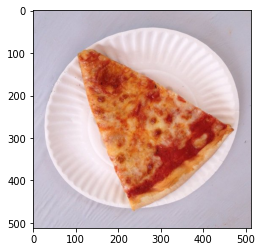

In [29]:
import matplotlib.image as mpimg

img = mpimg.imread("/tmp/pizza_not_pizza/pizza/1906287.jpg")

plt.imshow(img)

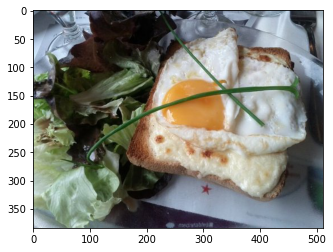

In [31]:
img = mpimg.imread("/tmp/pizza_not_pizza/not_pizza/3732661.jpg")

plt.imshow(img)

In [8]:
# to avoid bias, randomly assigne images to training or testing
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


PIZZA_SOURCE_DIR = "/tmp/pizza_not_pizza/pizza/"
TRAINING_PIZZA_DIR = "/tmp/pizza-not-pizza/training/pizza/"
TEST_PIZZA_DIR = "/tmp/pizza-not-pizza/test/pizza/"
NOT_PIZZA_SOURCE_DIR = "/tmp/pizza_not_pizza/not_pizza/"
TRAINING_NOT_PIZZA_DIR = "/tmp/pizza-not-pizza/training/not_pizza/"
TEST_NOT_PIZZA_DIR = "/tmp/pizza-not-pizza/test/not_pizza/"

split_size = .9
split_data(PIZZA_SOURCE_DIR, TRAINING_PIZZA_DIR, TEST_PIZZA_DIR, split_size)
split_data(NOT_PIZZA_SOURCE_DIR, TRAINING_NOT_PIZZA_DIR, TEST_NOT_PIZZA_DIR, split_size)

In [9]:
print(len(os.listdir('/tmp/pizza-not-pizza/training/pizza/')))
print(len(os.listdir('/tmp/pizza-not-pizza/test/pizza/')))
print(len(os.listdir('/tmp/pizza-not-pizza/training/not_pizza/')))
print(len(os.listdir('/tmp/pizza-not-pizza/test/not_pizza/')))

884
99
884
99


In [10]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

83697664/83683744 [==============================] - 2s 0us/step


In [11]:
base_model.trainable = False

In [12]:
inputs = tf.keras.Input(shape=(150, 150, 3))

x = base_model(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
# A Dense classifier with a single unit (binary classification)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
model.compile(optimizer= tf.keras.optimizers.Adam(),
              loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [14]:
TRAINING_DIR = "/tmp/pizza-not-pizza/training"
train_datagen = ImageDataGenerator(rescale=1.0/255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip=True, vertical_flip= True)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size = 52,
    class_mode = 'binary',
    target_size = (150, 150))

VALIDATION_DIR = "/tmp/pizza-not-pizza/test"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size = 9,
    class_mode = 'binary',
    target_size = (150, 150))

Found 1768 images belonging to 2 classes.
Found 198 images belonging to 2 classes.


In [15]:
earlyStop = tf.keras.callbacks.EarlyStopping(min_delta=0.01, patience=2, restore_best_weights = True)

In [16]:
history = model.fit(train_generator, epochs = 20, steps_per_epoch = 17, 
                    validation_data = validation_generator, validation_steps = 11, callbacks = [earlyStop])

Epoch 1/20
17/17 [==============================] - 25s 550ms/step - loss: 0.5283 - binary_accuracy: 0.6855 - val_loss: 0.2825 - val_binary_accuracy: 0.9091
Epoch 2/20
17/17 [==============================] - 8s 482ms/step - loss: 0.3208 - binary_accuracy: 0.8541 - val_loss: 0.2078 - val_binary_accuracy: 0.9394
Epoch 3/20
17/17 [==============================] - 8s 479ms/step - loss: 0.2505 - binary_accuracy: 0.8891 - val_loss: 0.1880 - val_binary_accuracy: 0.9293
Epoch 4/20
17/17 [==============================] - 8s 474ms/step - loss: 0.2630 - binary_accuracy: 0.8869 - val_loss: 0.1943 - val_binary_accuracy: 0.8990
Epoch 5/20
17/17 [==============================] - 8s 478ms/step - loss: 0.2443 - binary_accuracy: 0.8846 - val_loss: 0.1887 - val_binary_accuracy: 0.9495


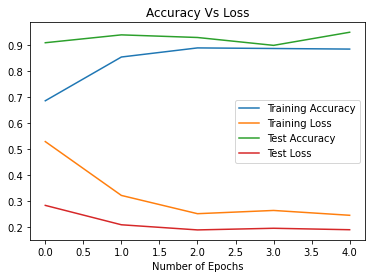

In [17]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['binary_accuracy']
val_acc=history.history['val_binary_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.plot(acc, label='Training Accuracy')
plt.plot(loss, label='Training Loss')
plt.plot(val_acc, label='Test Accuracy')
plt.plot(val_loss, label= "Test Loss")
plt.legend()
plt.title("Accuracy Vs Loss")
plt.xlabel("Number of Epochs")
plt.show()


# Desired output. Charts with training and validation metrics. 

In [18]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer= tf.keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(train_generator, epochs=10, callbacks=[earlyStop], validation_data=validation_generator, steps_per_epoch = 17, validation_steps = 11)

Epoch 1/10
17/17 [==============================] - 23s 730ms/step - loss: 0.2541 - binary_accuracy: 0.8767 - val_loss: 0.1459 - val_binary_accuracy: 0.9394
Epoch 2/10
17/17 [==============================] - 11s 613ms/step - loss: 0.2017 - binary_accuracy: 0.9242 - val_loss: 0.1289 - val_binary_accuracy: 0.9697
Epoch 3/10
17/17 [==============================] - 10s 599ms/step - loss: 0.2168 - binary_accuracy: 0.9106 - val_loss: 0.1722 - val_binary_accuracy: 0.9697
Epoch 4/10
17/17 [==============================] - 11s 619ms/step - loss: 0.1727 - binary_accuracy: 0.9253 - val_loss: 0.1741 - val_binary_accuracy: 0.9495


In [19]:
# import shutil 

# shutil.rmtree('/tmp/pizza-not-pizza')